In [2]:
!ls ./ -l

总用量 860
-rw-rw-r-- 1 lyz lyz  26191 9月  15 07:45  sample_submission.csv
drwxrwxr-x 2 lyz lyz 249856 7月  24 23:49  train
-rw-rw-r-- 1 lyz lyz 109657 9月  15 07:45  train.csv
drwxrwxr-x 2 lyz lyz  69632 7月  24 23:49  validation
-rw-rw-r-- 1 lyz lyz 416511 9月  15 10:04 '广告图片素材分类_baseline (1).ipynb'


In [1]:
import pandas as pd
import cv2, os
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
train_df = pd.read_csv('train.csv')
train_df['file_name'] = './train_512/' + train_df['file_name']

In [3]:
train_df = train_df[train_df['file_name'].apply(lambda x: os.path.exists(x))]

In [4]:
train_df.head()

,file_name,category
0,./train_512/395c09.jpg,C
1,./train_512/da9982.jpg,B
2,./train_512/193de3.jpg,A
3,./train_512/14062f.jpg,F
4,./train_512/e8ef0f.jpg,F


In [5]:
train_df['category'] = train_df['category'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5})

# 数据分析

In [6]:
def show_image(paths):
    plt.figure(figsize=(10, 8))
    for idx, path in enumerate(paths):
        plt.subplot(1, len(paths), idx+1)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])

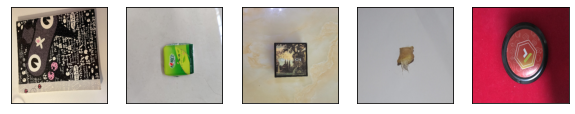

In [7]:
show_image(train_df.sample(5)['file_name'])

<AxesSubplot:>

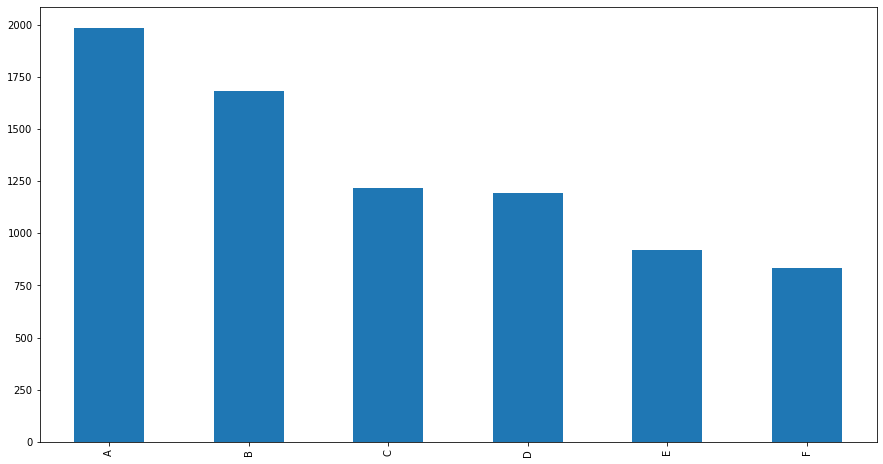

In [13]:
plt.figure(figsize=(15, 8))
train_df['category'].value_counts().plot(kind='bar')

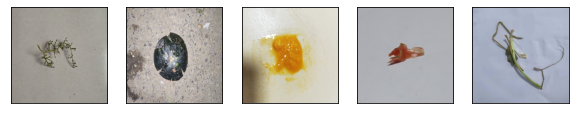

In [9]:
show_image(train_df[train_df['category'] == 0].sample(5)['file_name'])

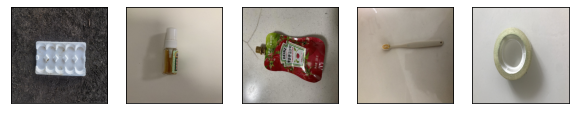

In [10]:
show_image(train_df[train_df['category'] == 1].sample(5)['file_name'])

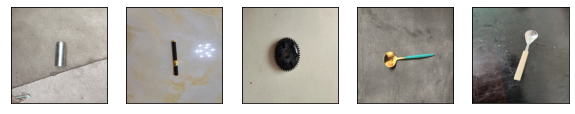

In [11]:
show_image(train_df[train_df['category'] == 2].sample(5)['file_name'])

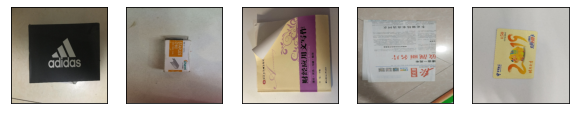

In [12]:
show_image(train_df[train_df['category'] == 3].sample(5)['file_name'])

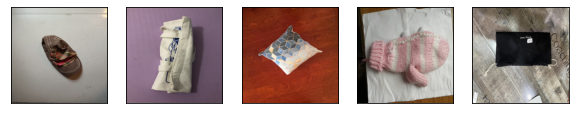

In [13]:
show_image(train_df[train_df['category'] == 4].sample(5)['file_name'])

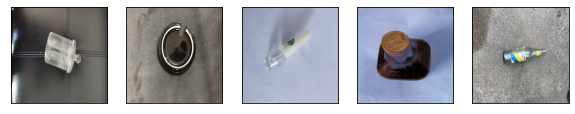

In [14]:
show_image(train_df[train_df['category'] == 5].sample(5)['file_name'])

# 模型训练

In [6]:
import os, sys, codecs, glob
from PIL import Image

import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.enabled = False

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [7]:
class XunFeiDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        self.transform = transform

    def __getitem__(self, index):
        # print(self.img_path[index], cv2.imread(self.img_path[index]).shape)
        
        try:
            img = Image.open(self.img_path[index]).convert('RGB')
        except:
            index = 0
            img = Image.open(self.img_path[index]).convert('RGB')
            
        if self.transform is not None:
            img = self.transform(img)
        
        label = torch.from_numpy(np.array([self.img_label[index]]))
        return img, label

    def __len__(self):
        return len(self.img_path)

In [8]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        # print(correct.shape)
        res = []
        for k in topk:
            # print(correct[:k].shape)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size))
            
        # print(res)
        return res

In [9]:
train_df = train_df.sample(frac = 1.0)

train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_df['file_name'].values[:-2000], train_df['category'].values[:-2000],
                        transforms.Compose([
                        transforms.Resize((300, 300)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.RandomAffine(5, scale=[0.95, 1.05]),
                        transforms.RandomCrop((256, 256)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=10, shuffle=True, num_workers=5,
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_df['file_name'].values[-2000:], train_df['category'].values[-2000:],
                        transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [10]:
import timm
model = timm.create_model('efficientnet_b4', num_classes=6, 
                          pretrained=True, in_chans=3)

In [11]:
model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=len(train_loader) / 10, gamma=0.95)

print('Epoch/Batch\t\tTrain: loss/Top1/Top3\t\tTest: loss/Top1/Top3')

for epoch in range(5):
    train_losss, train_acc1s, train_acc5s = [], [], []
    for i, data in enumerate(train_loader):
        scheduler.step()
        model = model.train()
        train_img, train_label = data
        optimizer.zero_grad()
        
        train_img = Variable(train_img).cuda()
        train_label = Variable(train_label.view(-1)).cuda()

        output = model(train_img)
        train_loss = loss_fn(output, train_label)
        
        train_loss.backward()
        optimizer.step()
        
        train_losss.append(train_loss.item())

        if i % int(10) == 0:
            val_losss, val_acc1s, val_acc5s = [], [], []
            
            with torch.no_grad():
                train_acc1, train_acc3 = accuracy(output, train_label, topk=(1, 3))
                train_acc1s.append(train_acc1.data.item())
                train_acc5s.append(train_acc3.item())
            
                for data in val_loader:
                    val_images, val_labels = data
                    
                    # val_images = Variable(val_images).cuda(async=True)
                    # val_labels = Variable(val_labels.view(-1)).cuda()

                    val_images = Variable(val_images).cuda()
                    val_labels = Variable(val_labels.view(-1)).cuda() 
                    
                    output = model(val_images)
                    val_loss = loss_fn(output, val_labels)
                    val_acc1, val_acc3 = accuracy(output, val_labels, topk=(1, 3))
                    
                    val_losss.append(val_loss.item())
                    val_acc1s.append(val_acc1.item())
                    val_acc5s.append(val_acc3.item())
                    
            logstr = '{0:2s}/{1:6s}\t\t{2:.4f}/{3:.4f}/{4:.4f}\t\t{5:.4f}/{6:.4f}/{7:.4f}'.format(
                    str(epoch), str(i),
                    np.mean(train_losss, 0), np.mean(train_acc1s, 0), np.mean(train_acc5s, 0),
                    np.mean(val_losss, 0), np.mean(val_acc1s, 0), np.mean(val_acc5s, 0),
                )
            torch.save(model.state_dict(), '.model_{0}.pt'.format(epoch))
            print(logstr)

Epoch/Batch		Train: loss/Top1/Top3		Test: loss/Top1/Top3


/home/lyz/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 /0     		1.8593/40.0000/60.0000		2.1504/23.1000/60.2000
0 /10    		1.9467/35.0000/65.0000		1.4758/47.8500/79.0500
0 /20    		1.7531/46.6667/73.3333		1.2685/53.9000/87.8500
0 /30    		1.6131/50.0000/77.5000		1.1173/59.4000/88.1500
0 /40    		1.4866/54.0000/82.0000		1.0053/61.7500/91.2500
0 /50    		1.3928/55.0000/85.0000		1.0289/62.1500/92.1000
0 /60    		1.3530/58.5714/87.1429		0.9743/63.7000/92.0500
0 /70    		1.3042/61.2500/87.5000		0.9886/63.7000/91.8500
0 /80    		1.2334/63.3333/87.7778		0.9475/64.9500/94.3000
0 /90    		1.2062/65.0000/87.0000		0.9637/66.3000/93.8000
0 /100   		1.1606/66.3636/88.1818		0.9820/65.1500/92.4000
0 /110   		1.1479/65.0000/88.3333		0.9192/65.8000/94.6000
0 /120   		1.1224/66.1538/89.2308		0.8736/68.3000/94.5000
0 /130   		1.1056/65.0000/90.0000		0.8840/68.2000/94.6000
0 /140   		1.0862/65.3333/90.0000		0.9017/68.8500/93.5000
0 /150   		1.0752/63.7500/90.6250		0.8572/68.6500/94.6000
0 /160   		1.0638/63.5294/91.1765		0.8759/68.1000/94.3000
0 /170   		1.0

In [39]:
test_df = pd.DataFrame({'path': glob.glob('./validation_512/*')})
test_df['label'] = 0

In [41]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_df['path'].values[:], test_df['label'].values[:],
                        transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=50, shuffle=False, num_workers=5,
)

In [42]:
pred_tta = []
for tti in range(5):
    pred = []
    with torch.no_grad():
        for t, (x, y) in enumerate(test_loader):
            x_var = Variable(x).cuda(async=True)
            y_var = Variable(y).cuda()
            scores = model(x_var)
            pred.append(scores.data.cpu().numpy())
    pred = np.concatenate(pred, 0)    
    print(tti)
    pred_tta.append(pred)

pred = np.mean(pred_tta, axis=0)

0
1
2
3
4


In [43]:
test_df['label'] = pred.argmax(1)
test_df['id'] = test_df['path'].apply(lambda x: x.split('/')[-1])

In [44]:
test_df['label'] = test_df['label'].map({0:'A', 1:'B', 2:"C", 3:"D", 4:'E', 5:"F"})

In [45]:
test_df[['id','label']].to_csv('submit.csv', index=None)